Исследование моделей OCR для распознания китайского языка.

# Описание задачи 

1. **Изучить существующие open-source OCR модели**, выбрать из них лучшую модель. 

* Критерии оценки моделей предложить самостоятельно. 

* Модель должна лучше всего себя показывать на приложенных картинках (опционально: собрать дополнительный валидационный датасет с картинками с финансовой отчетностью). Результат исследования описать в отчете.

2. **Написать код, который создает микросервис на основе FastAPI и упаковывает его в Docker образ.**
* Микросервис должен на вход принимать картинку с отчетностью, на выходе отдавать распарсенный текст (с разделением строк через \n).

# О моделях

Одним из основных приоритетов является качественное распознание китайского языка. Учитывая это, были рассмотрены следующие модели:

1. **Tesseract OCR** - один из наиболее известных и широко используемых OCR-инструментов, поддерживающий различные языки, включая китайский. Он открыт и бесплатно доступен, но может показывать не лучшие результаты на изображениях с низким качеством.



2. **PaddleOCR от Baidu** - обеспечивает поддержку многих языков и специально оптимизирован для азиатских языков, включая китайский. Эта модель показывает высокую точность на разнообразных датасетах.



3. **EasyOCR** - также поддерживает работу с китайским языком и может быть использована в продакшен-приложениях. Она достаточно эффективна и легко интегрируется.

#  Библиотеки

In [1]:
from functools import wraps
import os
import time

from collections import defaultdict
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cv2

import easyocr
from paddleocr import PaddleOCR
import pytesseract

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)

# Технические функции

**Формирование списка путей для всех изображений с типом .png в директории**

In [3]:
def get_images_from_dir(path_to_imgs):
    test_files_name = [f for f in os.listdir(path_to_imgs) if f.endswith('.png')]
    lst_wth_full_path = []
    for test_file in test_files_name:
        file_path = os.path.join(path_to_imgs, test_file)
        lst_wth_full_path.append(file_path)
    return lst_wth_full_path

**Загрузка изображений в список**

In [4]:
def get_lst_wth_images(lst_wth_full_path):
    lst_images = []
    for path in lst_wth_full_path:
        image = cv2.imread(path)
        lst_images.append(image)
    return lst_images

**Отрисовка изображений**

In [5]:
def plot_images(lst_images, title):
    fig = plt.figure(figsize=(15,10))
    plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.95)
    for i in range(len(lst_images)):
        plt.suptitle(f'{title}', fontsize=15, fontweight='bold')
        fig.add_subplot(3,3, i+1)
        plt.title(f'Таблица №{i+1}', fontsize=13, fontweight='bold')
        plt.imshow(lst_images[i], cmap='gray')
        plt.grid(False)
        plt.ylabel('Высота', fontsize=9)
        plt.xlabel('Ширина', fontsize=9)
    plt.tight_layout()

# Знакомство с данными

In [6]:
path_to_dir = '/Users/satanislav/Documents/pdf_from_chinese/test/images/'
lst_wth_full_path = get_images_from_dir(path_to_dir)
lst_images = get_lst_wth_images(lst_wth_full_path)

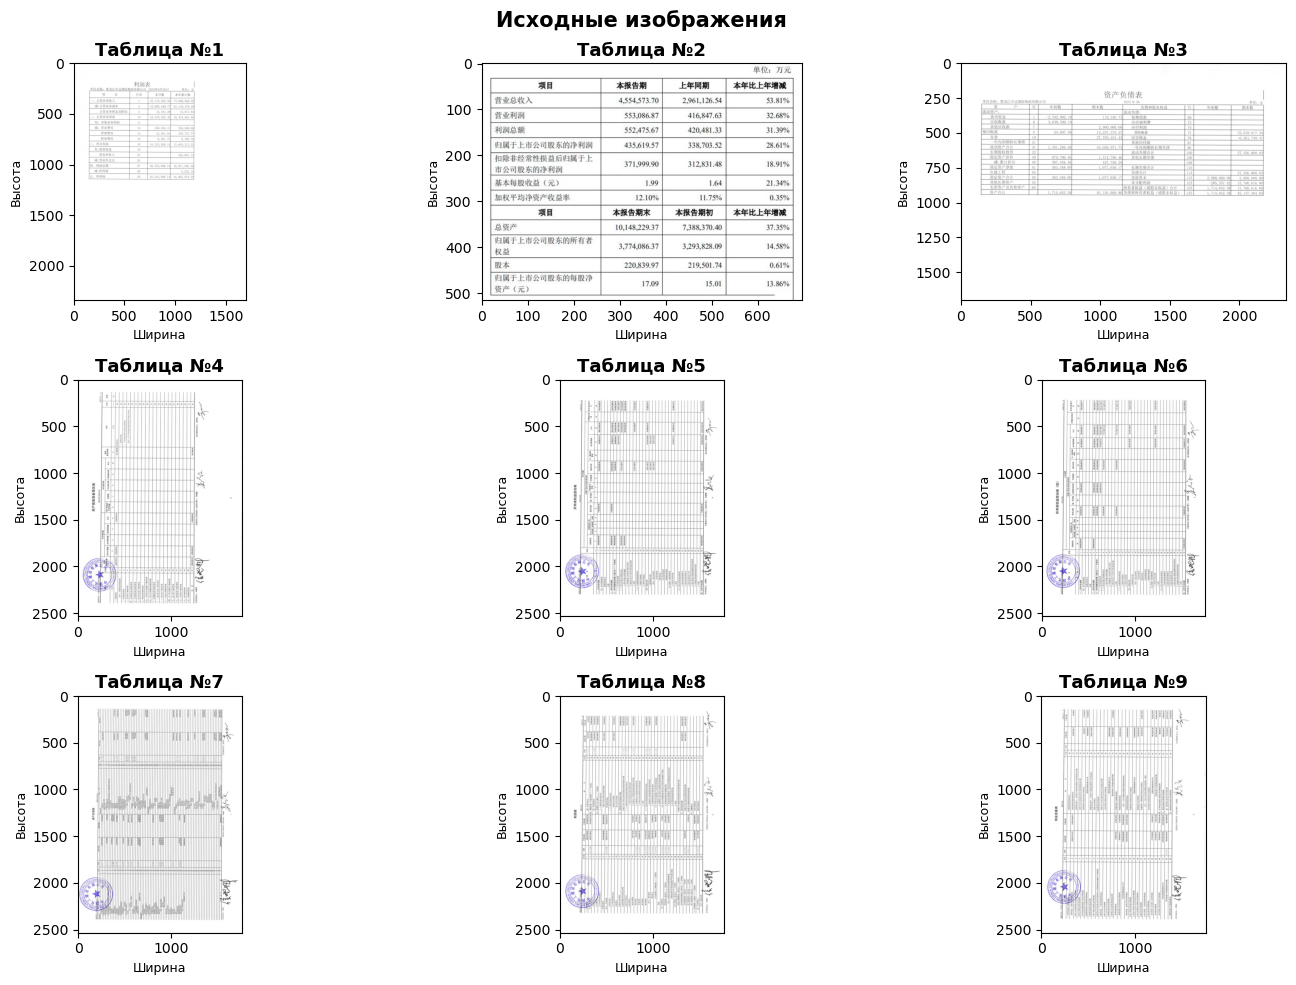

In [7]:
plot_images(lst_images, 'Исходные изображения')

* Исходные изображения могут изначально находится в разном положении, например, вертикальном или под углом.
* Кроме самих таблиц, на изображениях присутствую надписи и другие объекты(часть печати, подписи).

В дальнейшем проведу предобработку датасета по выделению целевой части (таблиц) на каждом png, чтобы исключить их влияние на качество распознания.

# Предобработка датасета датасета

## Поворот изображения по горизонтали

Для того, что бы автоматически позиционировать картинки в горизонтальнео положение, напишу следующие функции:

* 1-ая функция определяет угол, на который необходимо повернуть изображение
* 2-ая функция пововрачивает изображение

In [8]:
def average_angle(lines):
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        angles.append(angle)
    return np.median(angles)

In [9]:
def rotate_to_horizontal(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
    angle = average_angle(lines)
    if not np.isnan(angle):
        size_reverse = np.array(image.shape[1::-1])
        M = cv2.getRotationMatrix2D(tuple(size_reverse / 2.), angle, 1.)
        MM = np.absolute(M[:,:2])
        size_new = MM @ size_reverse
        M[:,-1] += (size_new - size_reverse) / 2.
        return cv2.warpAffine(image, M, tuple(size_new.astype(int)))

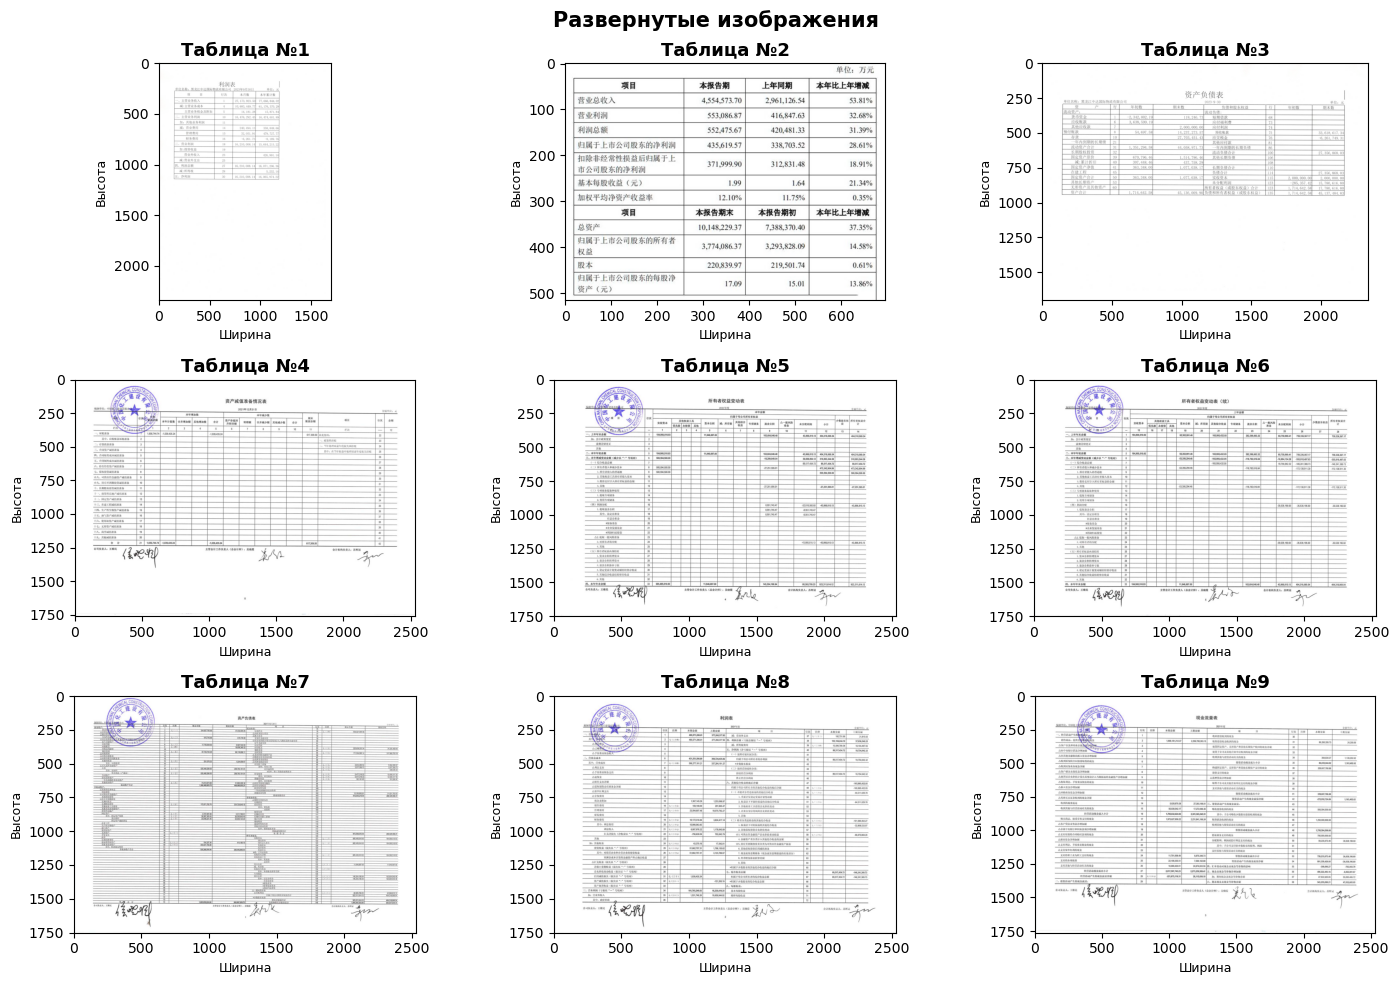

In [10]:
lst_images_origins = list(map(rotate_to_horizontal,lst_images))
plot_images(lst_images_origins, 'Развернутые изображения')

## Аугментация изображений

Чтобы определить явно границы таблиц на картинках, проведем аугментацию изображений:

1. Так как цвет нам не важен, отобразим все в черно-белом цвете
2. По возможности уберем шум
3. Сделаем инверсию (текст белым, а фон черным)
4. Увеличим толщину тексты и линий, что лучше определять контуры больших объектов(самый большой объект на изображении это таблица)

In [11]:
def get_aug_image(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresholded_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    inverted_image = cv2.bitwise_not(thresholded_image)
    dilated_image = cv2.dilate(inverted_image,None, iterations=5)
    return dilated_image

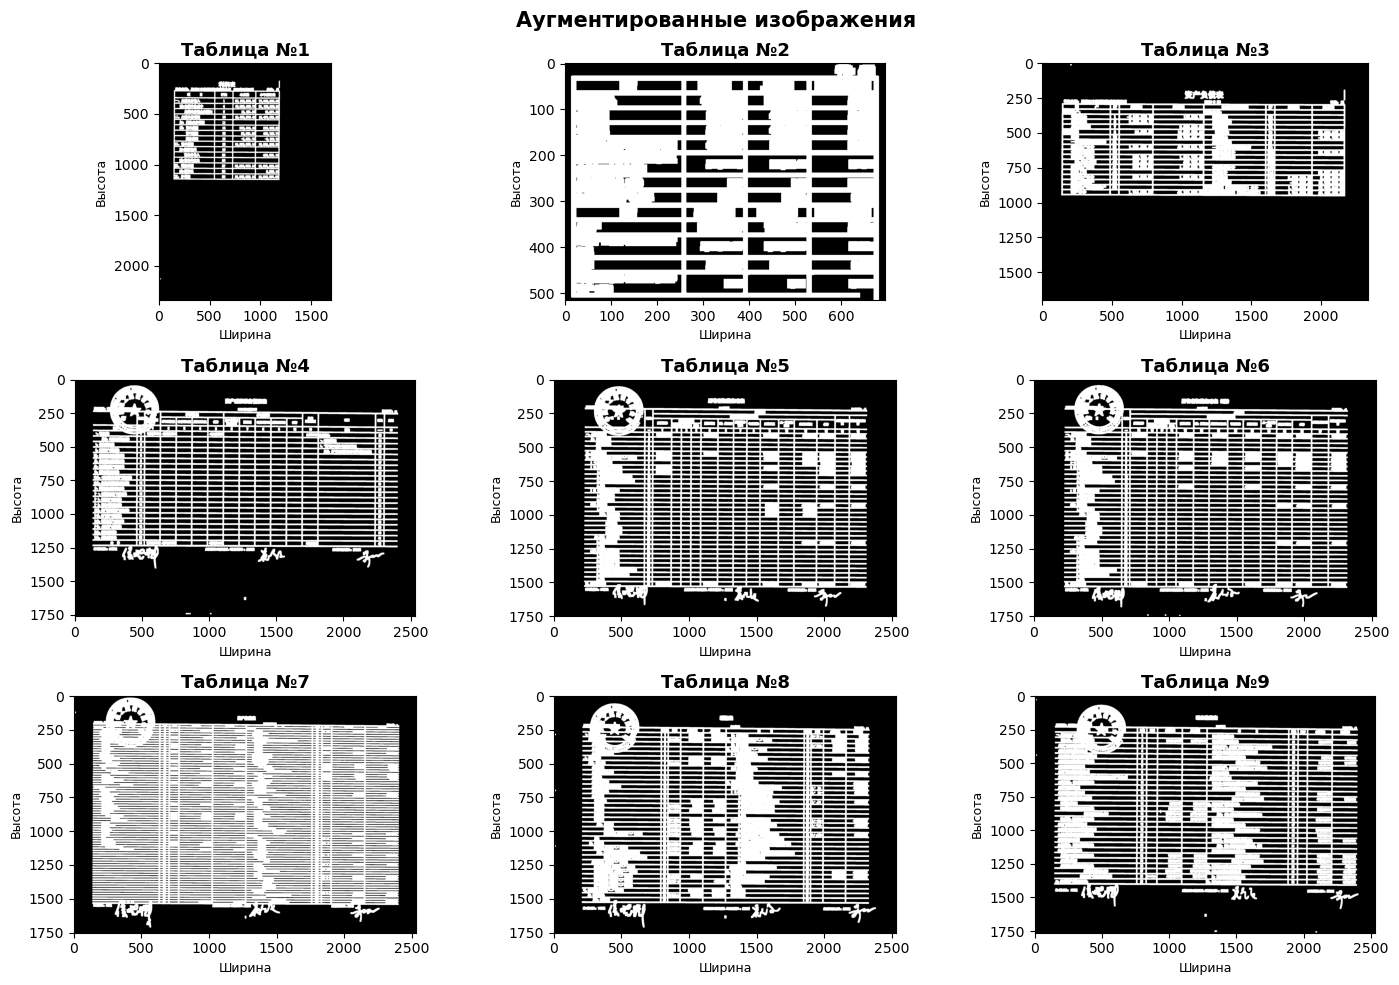

In [12]:
lst_images_aug = list(map(get_aug_image, lst_images_origins))
plot_images(lst_images_aug, 'Аугментированные изображения')

## Определение контуров таблицы

1. Определим контруры таблицы. Чтобы адаптировать выбор коэффициента размера epsilon для разных обьектов, буду использовать метод, при котором анализируются результаты изменения scale относительно площади максимального контура для каждого, а затем выбирается scale, при котором найден контур с максимальной площадью. Для наглядности выведу лучшее значение epsilon для каждой таблицы.

2. Расположим 4 точки по контуру самого большого прямоугольника.

3. Найдем ширину и высоту нового изображения

4. Применим изменения

In [13]:
def get_contour_of_table(image):
    
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    best_scale = None
    max_area = 0
    contour_with_max_area = None
    for scale in np.linspace(0.005, 0.05, 10):
        for contour in contours:
            peri = cv2.arcLength(contour, True)
            epsilon = scale * peri
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            if len(approx) == 4:
                area = cv2.contourArea(approx)
                if area > max_area:
                    max_area = area
                    contour_with_max_area = approx
                    best_scale = scale
    print(f"Best scale for image: {best_scale}")

    return contour_with_max_area

In [14]:
def calculate_distance_between_2points(p1, p2):
    dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
    return dis

In [15]:
def order_points(pts):
    pts = pts.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

In [16]:
def calculate_new_width_and_height_of_image(original_image, contour_with_max_area_ordered):
    existing_image_width = original_image.shape[1]
    existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)
    distance_between_top_left_and_top_right = calculate_distance_between_2points(contour_with_max_area_ordered[0],
                                                                                 contour_with_max_area_ordered[1])
    distance_between_top_left_and_bottom_left = calculate_distance_between_2points(contour_with_max_area_ordered[0],
                                                                                   contour_with_max_area_ordered[3])
    aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right
    new_image_width = existing_image_width_reduced_by_10_percent
    new_image_height = int(new_image_width * aspect_ratio)
    return new_image_width, new_image_height

In [17]:
def apply_perspective_transform(new_image_width, new_image_height, contour_with_max_area_ordered, image):
    pts1 = np.float32(contour_with_max_area_ordered)
    pts2 = np.float32([[0, 0], [new_image_width, 0], [new_image_width, new_image_height], [0, new_image_height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    perspective_corrected_image = cv2.warpPerspective(image, matrix, (new_image_width, new_image_height))
    return perspective_corrected_image

In [18]:
lst_perspective_images = []

for indx, img in enumerate(lst_images_aug):
    contour_with_max_area = get_contour_of_table(img)
    contour_with_max_area_ordered = order_points(contour_with_max_area)
    new_image_width, new_image_height = calculate_new_width_and_height_of_image(lst_images_origins[indx],
                                                                                contour_with_max_area_ordered)
    perspective_corrected_image = apply_perspective_transform(new_image_width,
                                                              new_image_height,
                                                              contour_with_max_area_ordered,
                                                              lst_images_origins[indx])
    lst_perspective_images.append(perspective_corrected_image)

Best scale for image: 0.020000000000000004
Best scale for image: 0.020000000000000004
Best scale for image: 0.020000000000000004
Best scale for image: 0.015000000000000003
Best scale for image: 0.035
Best scale for image: 0.035
Best scale for image: 0.010000000000000002
Best scale for image: 0.010000000000000002
Best scale for image: 0.025000000000000005


У обьектов(таблицы) на разных изображения значение epsilon различается.

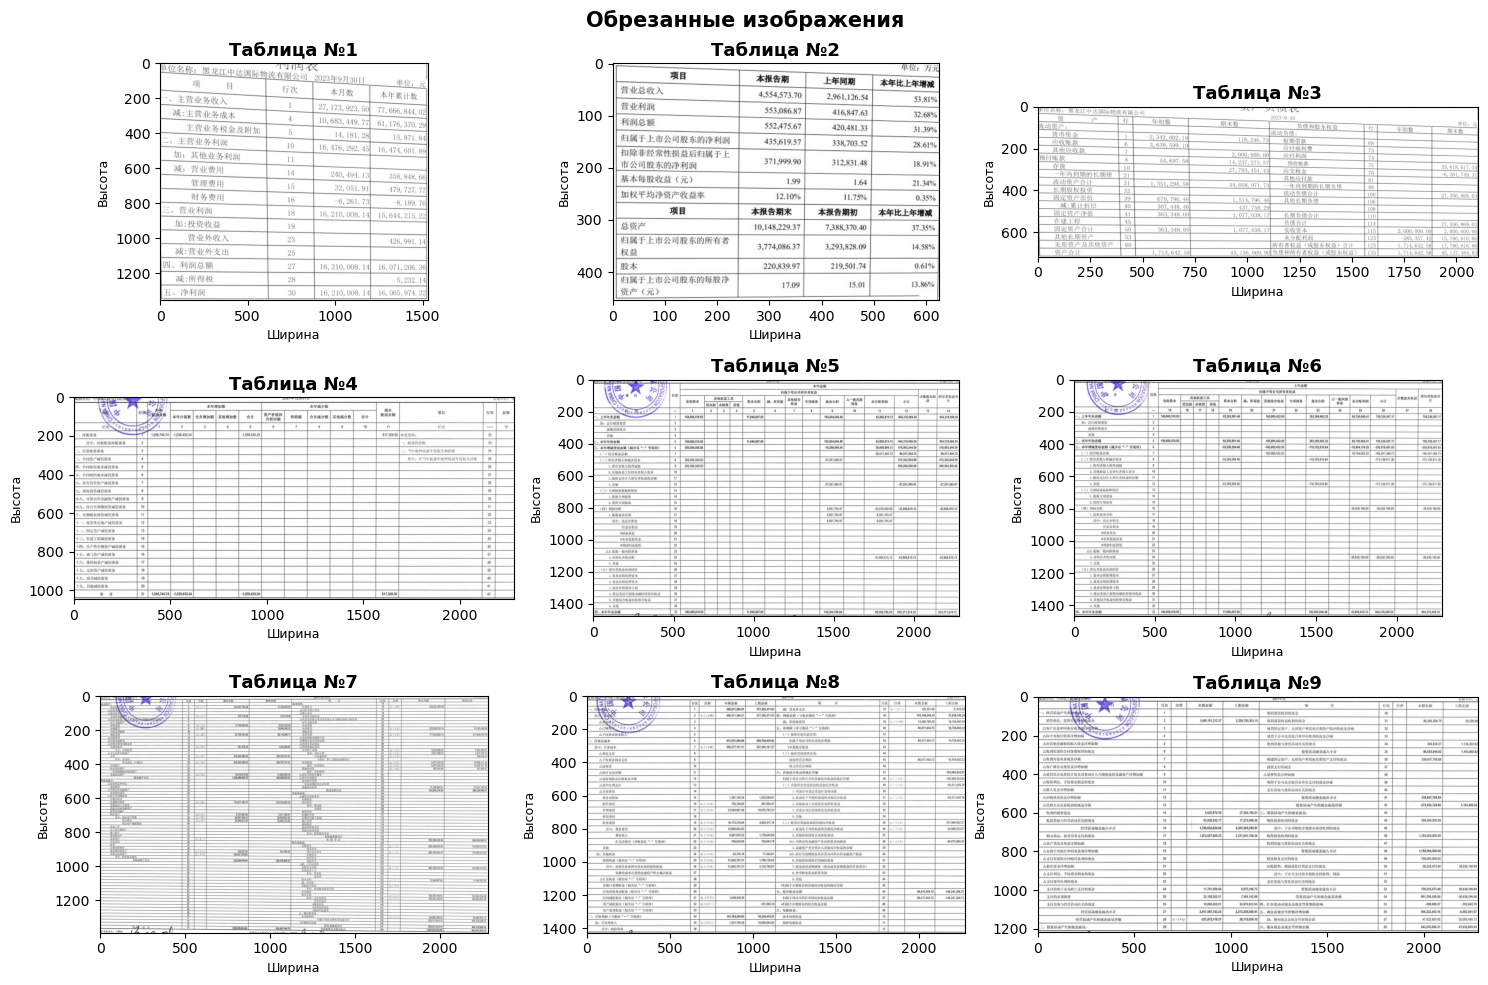

In [19]:
plot_images(lst_perspective_images, "Обрезанные изображения")

## Вывод

Датасет подготовлен к тестированию моделей на качество распознания.

В процессе предобработки выяснил, что таблицы на изображениях различются по размеру и наличию посторонних объектов (печать). Данные факты могут оказать негативное влияние на качество распознания. Чтобы не тратить время на адаптацию методов для всех возможных случаев, попробую переложить эти задачи на готовые алгоритмы.

# Тестирование моделей

**Критерии оценки моделей:**
- Точность распознавания: важно, чтобы текст с картинки был распознан правильно.
- Скорость обработки: обработка должна происходить быстро, особенно важно при большом потоке данных.
- Удобство интеграции и использование: насколько легко модель может быть интегрирована в нашу систему.

In [20]:
def get_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        return elapsed_time, result
    return wrapper

In [21]:
dct_times = {}

## Извлечений строк из таблицы

Для тестирования возьму произвольное изображение из датасета.

### PaddleOCR

In [22]:
@get_time
def get_rows_by_paddle_ocr(img):
    result = PaddleOCR(use_angle_cls=True, lang='ch').ocr(img, cls=True)
    list_with_lines = []
    for line in result[0]:
        list_with_lines.append(line)
    rows = defaultdict(list)

    for item in list_with_lines:
        block = item[0]
        average_y = sum(corner[1] for corner in block) / 4
        found_row = False
        for key in rows.keys():
            if abs(key - average_y) < 15:
                rows[key].append(item)
                found_row = True
                break
        if not found_row:
            rows[average_y] = [item]

    lst_with_rows = []
    sorted_rows = {i: rows[key] for i, key in enumerate(sorted(rows.keys()))}
    for row_index, blocks in sorted_rows.items():
        row_texts = [block[1][0] for block in sorted(blocks, key=lambda b: b[0][0][0])]
        lst_with_rows.append(" ".join(row_texts))
    return lst_with_rows

In [23]:
%%time
dct_times['PaddleOCR'], rows_by_paddle_ocr = get_rows_by_paddle_ocr(lst_perspective_images[1])

[2024/06/03 22:36:25] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/satanislav/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/satanislav/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=

### EasyOCR

In [24]:
@get_time
def get_rows_by_easy_ocr(img):
    results = easyocr.Reader(['ch_sim']).readtext(img)
    lines = []
    final_rows = []
    results_sorted = sorted(results, key=lambda x: (x[0][0][1] + x[0][2][1]) / 2)
    for bbox, text, prob in results_sorted:
        ymin = min(bbox[0][1], bbox[1][1], bbox[2][1], bbox[3][1])
        ymax = max(bbox[0][1], bbox[1][1], bbox[2][1], bbox[3][1])
        line_found = False
        for line in lines:
            line_height = line['ymax'] - line['ymin']
            if (line['ymin'] <= ymin <= line['ymax'] or 
                line['ymin'] <= ymax <= line['ymax'] or
                (ymax >= line['ymin'] and ymin <= line['ymax'])):
                overlap_min = max(line['ymin'], ymin)
                overlap_max = min(line['ymax'], ymax)
                overlap_height = overlap_max - overlap_min
                if overlap_height > line_height * 0.5:
                    line['texts'].append(text)
                    line['ymin'] = min(line['ymin'], ymin)
                    line['ymax'] = max(line['ymax'], ymax)
                    line_found = True
                    break
        if not line_found:
            lines.append({'texts': [text], 'ymin': ymin, 'ymax': ymax})
    for line in lines:
        final_rows.append(" ".join(sorted(line['texts'], key=lambda t: t[0].lower())))
    return final_rows

In [25]:
%%time
dct_times['EasyOCR'], rows_by_easy_ocr = get_rows_by_easy_ocr(lst_perspective_images[1])

CPU times: user 2.24 s, sys: 263 ms, total: 2.5 s
Wall time: 2.74 s


### Pytesseract

In [26]:
@get_time
def get_rows_by_pytesseract(img):
    pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'
    rows_by_pytesseract = []
    for row_texts in pytesseract.image_to_string(img, lang='chi_sim').split('\n'):
        rows_by_pytesseract.append("".join(row_texts))
    return rows_by_pytesseract

In [27]:
dct_times['Pytesseract'], rows_by_pytesseract = get_rows_by_pytesseract(lst_perspective_images[1])

## Сравнение результатов

In [28]:
def calculate_metrics(list1, list2):
    set_list1 = set(list1)
    set_list2 = set(list2)
    true_positives = len(set_list1.intersection(set_list2))
    if len(list1) > 0:
        precision = true_positives / len(list1)
    else:
        precision = 0 
    if len(list2) > 0:
        recall = true_positives / len(list2)
    else:
        recall = 0
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0

    return precision, recall, f1_score

In [29]:
true = ['项目 本报告期 上年同期 本年比上年增减',
        '营业总收入 4,554,573.70 2,961,126.54 53.81%',
        '营业利润 553,086.87 416,847.63 32.68%',
        '利润总额 552,475.67 420,481.33 31.39%',
        '归属于上市公司股东的净利润 435,619.57 338,703.52 28.61%',
        '扣除非经常性损益后归属于上 市公司股东的净利润 371,999.90 312,831.48 18.91%',
        '基本每股收益（元) 1.99 1.64 21.34%',
        '加权平均净资产收益率 12.10% 11.75% 0.35%',
        '项目 本报告期末 本报告期初 本年比上年增减',
        '总资产 10,148,229.37 7,388,370.40 37.35%',
        '归属于上市公司股东的所有者 3,774,086.37 3,293,828.09 14.58%',
        '股本 220,839.97 219,501.74 0.61%',
        '归属于上市公司股东的每股净  17.09% 15.01% 13.86%']

In [30]:
df_result = pd.concat([pd.DataFrame({'Pytesseract': rows_by_pytesseract}),
                       pd.DataFrame({'Easy_OCR': rows_by_easy_ocr}),
                       pd.DataFrame({'Paddle_OCR': rows_by_paddle_ocr}),
                       pd.DataFrame({'True': true})], axis=1)


df_result.index.name = 'Rows'

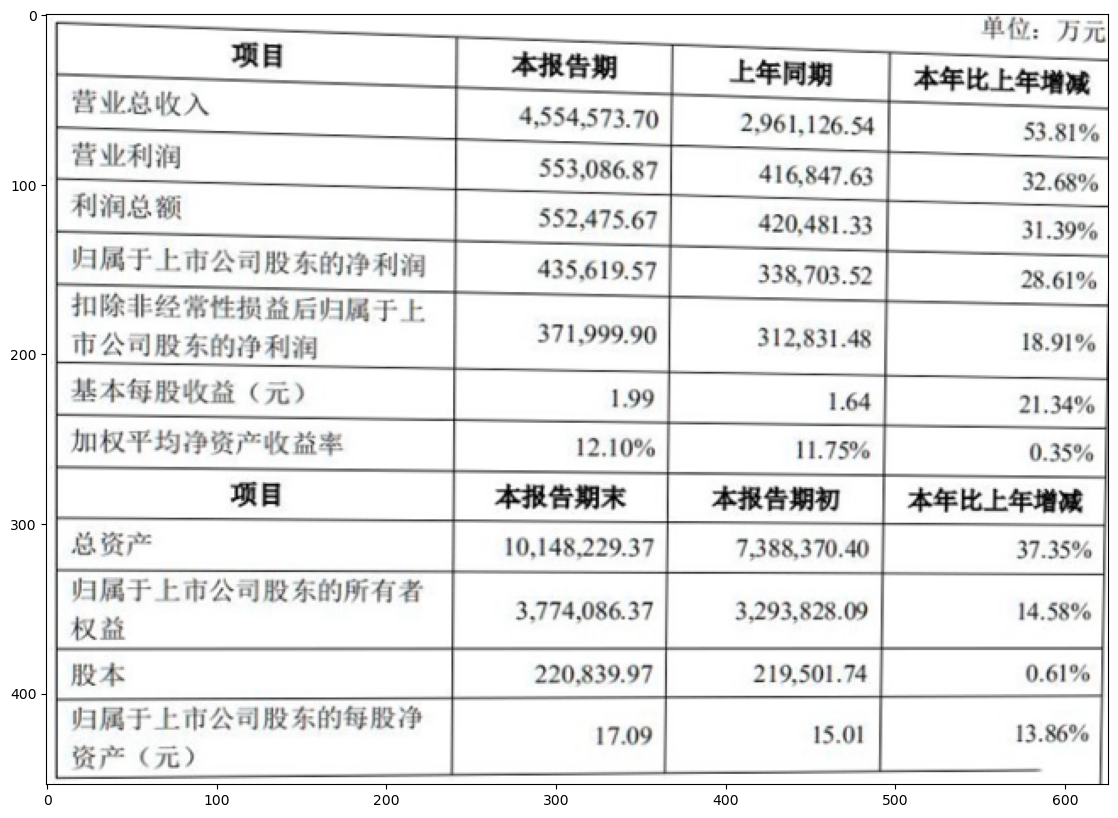

In [31]:
fig = plt.figure(figsize=(15,10))
plt.imshow(lst_perspective_images[1]);

In [32]:
df_result

,Pytesseract,Easy_OCR,Paddle_OCR,True
Rows,,,,
0,单位万元,单位: 万元,项目 单位：万元,项目 本报告期 上年同期 本年比上年增减
1,,上年同期 本报告期 本年比上年增碱 项目,本报告期 上年同期 本年比上年增减,"营业总收入 4,554,573.70 2,961,126.54 53.81%"
2,项目,"2.961.126.91 4,554573.70 菅业总收入","营业总收入 4,554,573.70 2,961,126.54","营业利润 553,086.87 416,847.63 32.68%"
3,,"53,819 菅业利润",营业利润 53.81%,"利润总额 552,475.67 420,481.33 31.39%"
4,本报告期 上年同期 本年比上年增减,"32.689 416.847.63 553,086.87","553,086.87 416,847.63 32.68%","归属于上市公司股东的净利润 435,619.57 338,703.52 28.61%"
5,营业总收入 4.554.573.70 2.961.126.54 53.81%,"420,481.33 552,475.67 利润总额","利润总额 552,475.67 420,481.33 31.39%","扣除非经常性损益后归属于上 市公司股东的净利润 371,999.90 312,831.48 18.91%"
6,营业利润 553.086.87 416.847.63 32.68%,31.399,"归属于上市公司股东的净利润 435,619.57 338,703.52 28.61%",基本每股收益（元) 1.99 1.64 21.34%
7,"利润总额 552,475.67 420.481.33 31.39%","338,703.52 435.619.57 归属于上市公司股东的诤利润",扣除非经常性损益后归属于上,加权平均净资产收益率 12.10% 11.75% 0.35%
8,归属于上市公司股东的净利泣 435.619.57 338.703.52 28.61%,"28,610","市公司股东的净利润 371,999.90 312,831.48 18.91%",项目 本报告期末 本报告期初 本年比上年增减


In [33]:
dct_times

{'PaddleOCR': 4.128449208001257,
 'EasyOCR': 2.74490054200578,
 'Pytesseract': 0.6353705840010662}

EasyOCR самая быстрая, PaddleOCR работает дольше всех.

In [34]:
for model_name, res in {'Easy_OCR': rows_by_easy_ocr,
                        'Paddle_OCR': rows_by_paddle_ocr,
                        'Pytesseract': rows_by_pytesseract}.items():
    print()
    precision, recall, f1_score = calculate_metrics(true, res)
    print(f"Для модели {model_name}")
    print(f"Полноста-{recall}| Точность-{precision}| F1-{f1_score}")


Для модели Easy_OCR
Полноста-0.0| Точность-0.0| F1-0

Для модели Paddle_OCR
Полноста-0.3888888888888889| Точность-0.5384615384615384| F1-0.45161290322580644

Для модели Pytesseract
Полноста-0.0| Точность-0.0| F1-0


PaddleOCR лучше понимает структуру таблиц и точнее распознает текст.

# Итоговый вывод

Для качественного распознания текста изображений с таблицами, наилучших вариантом будет PaddleOCR. Несмотря на то что модель работает дольше аналогов, она обладает более высоким качество и гибкостью настроеек.